# Exploration 9. 폐렴아 기다려라! 🤒😶‍🌫️🤨

Kaggle: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia  
캐글 노트북: https://www.kaggle.com/amyjang/tensorflow-pneumonia-classification-on-x-rays

--- 
# 프로젝트 : 폐렴 진단기 성능개선 😏😌🤩

## Step 1. 실험환경 Set-up
- Batch size, Epoch 등을 변경해보기

### 🔥 Attempt-(1) 노드에 있는 코드 그대로 실행

In [4]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [5]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel


## Step 2. 데이터 준비하기
1. 원본 데이터를 가져와서 전처리 및 배치 구성 진행
2. augmentation 도입은 신중해야 함 -> 좌우 반전 정도의 augmentation 도입 가능

In [6]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print('훈련 데이터 갯수: {}'.format(len(train_filenames)))
print('테스트 데이터 갯수: {}'.format(len(test_filenames)))
print('검증 데이터 갯수: {}'.format(len(val_filenames)))

훈련 데이터 갯수: 5216
테스트 데이터 갯수: 624
검증 데이터 갯수: 16


#### - train에서 val 데이터 가져와서` train : val를 80:20으로 분할

In [7]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print('훈련 데이터 갯수: {}'.format(len(train_filenames)))
print('검증 데이터 갯수: {}'.format(len(val_filenames)))

훈련 데이터 갯수: 4185
검증 데이터 갯수: 1047


In [8]:
# 파일 이름에 힌트 있음
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1243-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person299_bacteria_1418.jpeg


In [9]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1060
Pneumonia images count in training set: 3125


#### - tf.data는 tensorflow에서 학습시킬 때, 배치처리 작업을 보다 효율적으로 할 수 있도록 해준다

In [10]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [11]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


#### - 현재 이미지에는 라벨 데이터가 없으므로, 파일 경로에 'NORMAL'과 'PNEUMONIA'를 이용하여 라벨 데이터를 만들어 주는 함수 만들기

In [12]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [13]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [14]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [15]:
for image, label in train_ds.take(1):  # train_ds.take(1): 하나의 데이터만 가져온다는 뜻
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [16]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [17]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

# Step 3. 데이터 시각화
- 학습용 데이터를 시각화하기 
- augmentation을 시도 후, `show_batch()` 함수를 통해 실제로 좌우 반전 등이 제대로 처리되었는지 확인

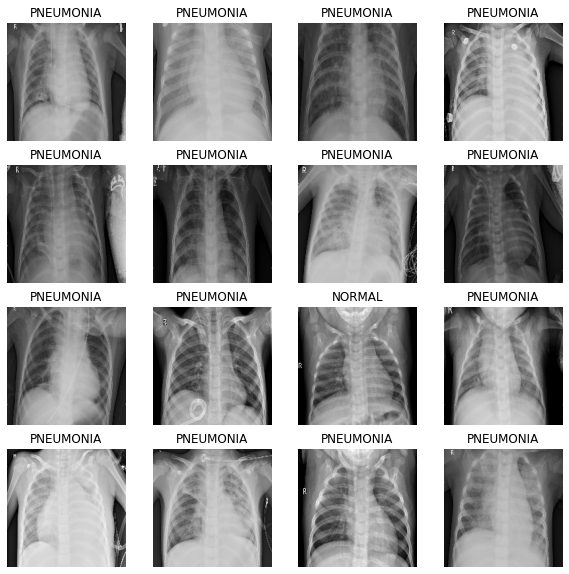

In [18]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

# Step 4. CNN 모델링
- **Convolution filter, 채널 개수, activation, 모델 구조** 등을 다양하게 바꾸어가며 실험해보기
- `BatchNormalization`과 `Dropout`을 한 모델 안에서 동시에 사용하였는데,,, **"특이한 구성"**
    - `BatchNormalization`을 쓰거나 혹은 쓰지 않거나
    - `Dropout`을 쓰거나 혹은 쓰지 않거나  
    - `Dropout` 비율을 변경해보기

#### - BatchNormalization과 Dropout을 한 모델 안에서 동시에 사용

In [19]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [20]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [21]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

#### - batch normalization만 사용

In [22]:
def conv_batch_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation = 'relu', padding = 'same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation = 'relu', padding = 'same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [23]:
def dense_batch_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation = 'relu'),
        tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [24]:
def build_batch_model():
    model = Sequential([
        Input(shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        Conv2D(16, 3, activation = 'relu', padding = 'same'),
        Conv2D(16, 3, activation = 'relu', padding = 'same'),
        MaxPool2D(),
        
        conv_batch_block(32),
        conv_batch_block(64),
        
        conv_batch_block(128),
#         Dropout(0.2),
        
        conv_batch_block(256),
#         Dropout(0.2),
        
        Flatten(),
        dense_batch_block(512, 0.7),
        dense_batch_block(128, 0.5),
        dense_batch_block(64, 0.3),
        
        Dense(1, activation = 'sigmoid')
        
    ])
    
    return model

#### - Dropout만 사용

In [25]:
def conv_drop_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation = 'relu', padding = 'same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation = 'relu', padding = 'same'),
#         tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [26]:
def dense_drop_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation = 'relu'),
#         tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [27]:
def build_drop_model():
    model = Sequential([
        Input(shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        Conv2D(16, 3, activation = 'relu', padding = 'same'),
        Conv2D(16, 3, activation = 'relu', padding = 'same'),
        MaxPool2D(),
        
        conv_drop_block(32),
        conv_drop_block(64),
        
        conv_drop_block(128),
        Dropout(0.2),
        
        conv_drop_block(256),
        Dropout(0.2),
        
        Flatten(),
        dense_drop_block(512, 0.7),
        dense_drop_block(128, 0.5),
        dense_drop_block(64, 0.3),
        
        Dense(1, activation = 'sigmoid')
        
    ])
    
    return model

>정상보다 폐렴으로 분류된 이미지가 더 많아 데이터가 불균형하므로,
클래스 0(정상)의 가중치는 클래스 1(폐렴)의 가중치보다 훨씬 높게 부여하여, 
훈련 데이터가 균형을 이루게 하여 CNN이 잘 작동되도록 해야 한다.  

# Step 5. 데이터 imbalance 처리
1. 데이터의 imbalance 문제에 대처하기 위해 설정한 데이터 비율로 나누어진 `class_weight` 처리를 생략한다면 ? 
2. recall을 강조하기 위해 폐렴 데이터를 잘 맞추는 것을 더 강화하는 효과를 만들어낼 수는 없나 ?

In [28]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.97
Weight for PNEUMONIA: 0.67


# Step 6. 모델 훈련
- loss 함수를 변경하기는 어렵겠지만, optimizer나 learning rate 등의 변화를 고려해보기

In [29]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [30]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
sequential (Sequential)      (None, 45, 45, 32)        2160      
_________________________________________________________________
sequential_1 (Sequential)    (None, 22, 22, 64)        7392      
_________________________________________________________________
sequential_2 (Sequential)    (None, 11, 11, 128)       27072     
_________________________________________________________________
dropout (Dropout)            (None, 11, 11, 128)      

In [31]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 86s 189ms/step - loss: 0.3949 - accuracy: 0.8228 - precision: 0.9555 - recall: 0.7998 - val_loss: 0.7587 - val_accuracy: 0.7240 - val_precision: 0.7240 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 49s 187ms/step - loss: 0.2149 - accuracy: 0.9239 - precision: 0.9772 - recall: 0.9196 - val_loss: 1.2345 - val_accuracy: 0.7231 - val_precision: 0.7231 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 49s 188ms/step - loss: 0.2391 - accuracy: 0.9164 - precision: 0.9708 - recall: 0.9157 - val_loss: 1.0996 - val_accuracy: 0.7231 - val_precision: 0.7231 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 49s 190ms/step - loss: 0.1876 - accuracy: 0.9325 - precision: 0.9780 - recall: 0.9303 - val_loss: 0.1648 - val_accuracy: 0.9548 - val_precision: 0.9916 - val_recall: 0.9456
Epoch 5/25
261/261 [==============================] - 51s 196ms/step - loss: 0.1637 - accura

# Step 7. 결과 확인과 시각화
- 테스트 데이터로 훈련된 모델을 평가해보기
- accuracy를 고려해야겠지만 의료 영상 모델의 특성상 recall도 중요
- 훈련과정의 history 그래프를 시각화해보기
- 학습 진행 양상을 면밀히 분석해보기

> 🌀 Recall이란 실제 True인 것들 중에서 모델이 True라고 예측한 것의 비율이다.

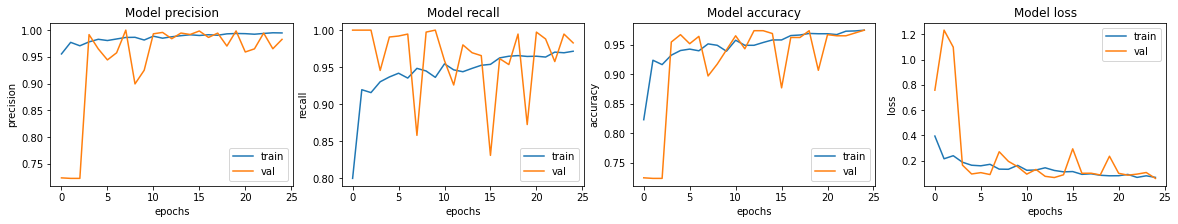

In [32]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [33]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 103ms/step - loss: 1.3672 - accuracy: 0.7324 - precision: 0.7024 - recall: 0.9923
Loss: 1.3672192096710205,
Accuracy: 0.7323718070983887,
Precision: 0.7023593187332153,
Recall: 0.9923076629638672


### 🔥🔥 Attempt-(2) Batch size, Epoch, optimizer 등 hyperparameter 변경해보기 

In [34]:
# history_optimizer = attempt(OPTIMIZER='sgd')        # Optimizer SGD로 변경
# history_batch = attempt(BATCH_SIZE=8)               # Batch size 8로 변경
# history_epochs = attempt(EPOCHS=40)                 # epoch 40으로 변경

In [35]:
# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 8
EPOCHS = 40

In [36]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [37]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/40
523/523 [==============================] - 97s 168ms/step - loss: 0.3036 - accuracy: 0.8628 - precision: 0.9665 - recall: 0.8456 - val_loss: 1.0728 - val_accuracy: 0.7231 - val_precision: 0.7231 - val_recall: 1.0000
Epoch 2/40
523/523 [==============================] - 87s 167ms/step - loss: 0.1994 - accuracy: 0.9250 - precision: 0.9768 - recall: 0.9214 - val_loss: 0.2223 - val_accuracy: 0.9231 - val_precision: 0.9956 - val_recall: 0.8979
Epoch 3/40
523/523 [==============================] - 88s 168ms/step - loss: 0.1693 - accuracy: 0.9356 - precision: 0.9798 - recall: 0.9329 - val_loss: 0.1084 - val_accuracy: 0.9663 - val_precision: 0.9891 - val_recall: 0.9641
Epoch 4/40
523/523 [==============================] - 88s 168ms/step - loss: 0.1354 - accuracy: 0.9511 - precision: 0.9846 - recall: 0.9494 - val_loss: 0.1323 - val_accuracy: 0.9500 - val_precision: 0.9958 - val_recall: 0.9349
Epoch 5/40
523/523 [==============================] - 88s 169ms/step - loss: 0.1264 - accura

Epoch 37/40
523/523 [==============================] - 83s 158ms/step - loss: 0.0108 - accuracy: 0.9968 - precision: 0.9994 - recall: 0.9963 - val_loss: 0.0699 - val_accuracy: 0.9798 - val_precision: 0.9893 - val_recall: 0.9827
Epoch 38/40
523/523 [==============================] - 83s 159ms/step - loss: 0.0209 - accuracy: 0.9941 - precision: 0.9984 - recall: 0.9938 - val_loss: 0.0631 - val_accuracy: 0.9812 - val_precision: 0.9854 - val_recall: 0.9887
Epoch 39/40
523/523 [==============================] - 87s 167ms/step - loss: 0.0217 - accuracy: 0.9926 - precision: 0.9989 - recall: 0.9912 - val_loss: 0.0675 - val_accuracy: 0.9817 - val_precision: 0.9880 - val_recall: 0.9867
Epoch 40/40
523/523 [==============================] - 86s 164ms/step - loss: 0.0227 - accuracy: 0.9932 - precision: 0.9984 - recall: 0.9925 - val_loss: 0.0512 - val_accuracy: 0.9856 - val_precision: 0.9907 - val_recall: 0.9894


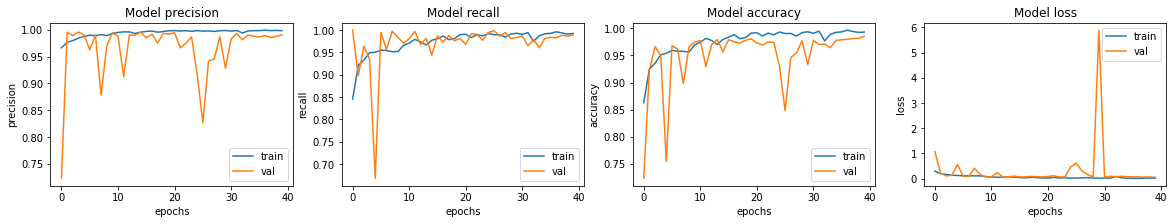

In [38]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [39]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 110ms/step - loss: 1.4438 - accuracy: 0.7981 - precision: 0.7578 - recall: 0.9949
Loss: 1.4438451528549194,
Accuracy: 0.7980769276618958,
Precision: 0.7578125,
Recall: 0.9948717951774597


#### - optimizer='sgd'로 변경

In [ ]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
#         optimizer='adam',
        optimizer='sgd'
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [ ]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

### 🔥🔥🔥 Attempt-(3) 데이터의 imbalance 문제에 대처하기 위해 설정한 데이터 비율로 나누어진 class_weight 처리 생략하기

In [40]:
with tf.device('/GPU:0'):
    model = build_model()
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name = 'precision'),
        tf.keras.metrics.Recall(name = 'recall')
    ]
    
    model.compile(
        optimizer = 'Rmsprop',
        loss = 'binary_crossentropy',
        metrics = METRICS
    )

In [41]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
#         class_weight=class_weight,
    )

Epoch 1/40
523/523 [==============================] - 96s 166ms/step - loss: 0.3334 - accuracy: 0.8651 - precision: 0.9292 - recall: 0.8868 - val_loss: 1.2532 - val_accuracy: 0.7226 - val_precision: 0.7226 - val_recall: 1.0000
Epoch 2/40
523/523 [==============================] - 87s 167ms/step - loss: 0.1879 - accuracy: 0.9343 - precision: 0.9545 - recall: 0.9576 - val_loss: 0.1915 - val_accuracy: 0.9327 - val_precision: 0.9921 - val_recall: 0.9143
Epoch 3/40
523/523 [==============================] - 87s 167ms/step - loss: 0.1458 - accuracy: 0.9496 - precision: 0.9665 - recall: 0.9659 - val_loss: 0.0887 - val_accuracy: 0.9644 - val_precision: 0.9773 - val_recall: 0.9734
Epoch 4/40
523/523 [==============================] - 89s 170ms/step - loss: 0.1135 - accuracy: 0.9614 - precision: 0.9742 - recall: 0.9741 - val_loss: 0.7506 - val_accuracy: 0.7466 - val_precision: 0.7406 - val_recall: 1.0000
Epoch 5/40
523/523 [==============================] - 88s 169ms/step - loss: 0.1080 - accura

Epoch 37/40
523/523 [==============================] - 86s 165ms/step - loss: 0.0167 - accuracy: 0.9961 - precision: 0.9982 - recall: 0.9965 - val_loss: 0.0985 - val_accuracy: 0.9779 - val_precision: 0.9854 - val_recall: 0.9841
Epoch 38/40
523/523 [==============================] - 85s 162ms/step - loss: 0.0143 - accuracy: 0.9969 - precision: 0.9986 - recall: 0.9973 - val_loss: 0.2301 - val_accuracy: 0.9649 - val_precision: 0.9578 - val_recall: 0.9953
Epoch 39/40
523/523 [==============================] - 86s 164ms/step - loss: 0.0141 - accuracy: 0.9977 - precision: 0.9994 - recall: 0.9976 - val_loss: 0.1153 - val_accuracy: 0.9764 - val_precision: 0.9796 - val_recall: 0.9881
Epoch 40/40
523/523 [==============================] - 85s 162ms/step - loss: 0.0191 - accuracy: 0.9959 - precision: 0.9981 - recall: 0.9965 - val_loss: 0.1447 - val_accuracy: 0.9745 - val_precision: 0.9932 - val_recall: 0.9714


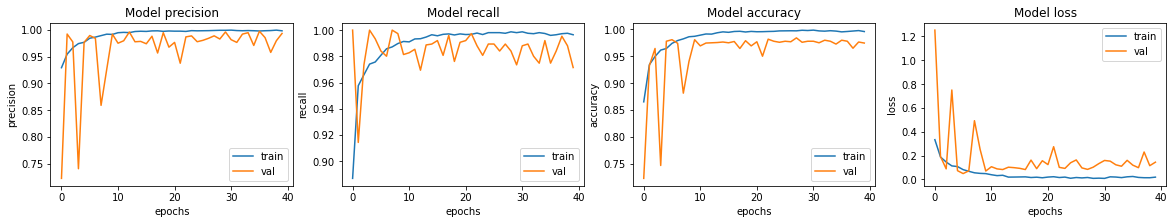

In [42]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [43]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 108ms/step - loss: 2.9370 - accuracy: 0.8077 - precision: 0.7689 - recall: 0.9897
Loss: 2.936978816986084,
Accuracy: 0.807692289352417,
Precision: 0.7689242959022522,
Recall: 0.9897435903549194


In [44]:
# history_weight = attempt(CLASS_WEIGHT=False)  # class_weight 생략

### 🔥🔥🔥🔥 Attempt-(4) Hyperparameter 원래대로 + Batch Normalization만 사용

In [45]:
# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 25

In [46]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/40
523/523 [==============================] - 98s 170ms/step - loss: 0.0160 - accuracy: 0.9975 - precision: 0.9995 - recall: 0.9971 - val_loss: 0.1112 - val_accuracy: 0.9788 - val_precision: 0.9919 - val_recall: 0.9787
Epoch 2/40
523/523 [==============================] - 88s 169ms/step - loss: 0.0155 - accuracy: 0.9977 - precision: 0.9989 - recall: 0.9981 - val_loss: 0.2115 - val_accuracy: 0.9519 - val_precision: 0.9848 - val_recall: 0.9482
Epoch 3/40
523/523 [==============================] - 88s 169ms/step - loss: 0.0174 - accuracy: 0.9971 - precision: 0.9989 - recall: 0.9973 - val_loss: 0.1586 - val_accuracy: 0.9769 - val_precision: 0.9906 - val_recall: 0.9774
Epoch 4/40
523/523 [==============================] - 89s 171ms/step - loss: 0.0122 - accuracy: 0.9974 - precision: 0.9989 - recall: 0.9976 - val_loss: 0.1031 - val_accuracy: 0.9793 - val_precision: 0.9854 - val_recall: 0.9861
Epoch 5/40
523/523 [==============================] - 89s 170ms/step - loss: 0.0130 - accura

Epoch 37/40
523/523 [==============================] - 87s 167ms/step - loss: 0.0211 - accuracy: 0.9976 - precision: 0.9989 - recall: 0.9979 - val_loss: 0.1302 - val_accuracy: 0.9822 - val_precision: 0.9893 - val_recall: 0.9860
Epoch 38/40
523/523 [==============================] - 86s 165ms/step - loss: 0.0040 - accuracy: 0.9986 - precision: 0.9998 - recall: 0.9982 - val_loss: 0.1784 - val_accuracy: 0.9707 - val_precision: 0.9853 - val_recall: 0.9742
Epoch 39/40
523/523 [==============================] - 88s 169ms/step - loss: 0.0053 - accuracy: 0.9993 - precision: 0.9997 - recall: 0.9994 - val_loss: 0.1528 - val_accuracy: 0.9798 - val_precision: 0.9920 - val_recall: 0.9801
Epoch 40/40
523/523 [==============================] - 87s 166ms/step - loss: 0.0072 - accuracy: 0.9986 - precision: 0.9995 - recall: 0.9986 - val_loss: 0.3971 - val_accuracy: 0.9697 - val_precision: 0.9683 - val_recall: 0.9907


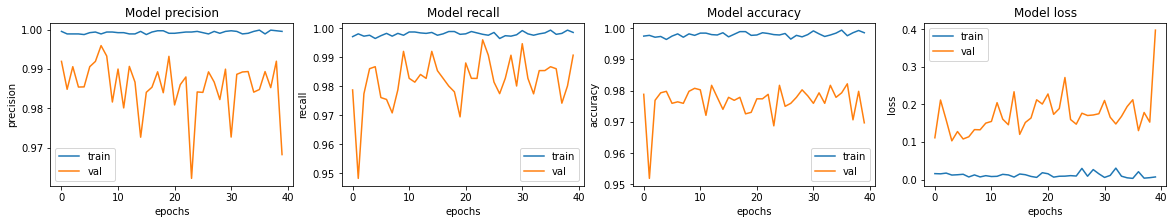

In [47]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [48]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 103ms/step - loss: 6.8048 - accuracy: 0.7228 - precision: 0.6927 - recall: 1.0000
Loss: 6.804835319519043,
Accuracy: 0.7227563858032227,
Precision: 0.6927176117897034,
Recall: 1.0


In [49]:
# attempt_ndo_normal = attempt_ndo()                # Drop out 제거

### 🔥🔥🔥🔥🔥 Attempt-(5) Dropout 모델만 사용

In [50]:
with tf.device('/GPU:0'):
    model = build_drop_model()
    
    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name = 'precision'),
        tf.keras.metrics.Recall(name = 'recall')
    ]
    
    model.compile(
        optimizer = 'Adam',
        loss = 'binary_crossentropy',
        metrics = METRICS
    )

In [51]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/40
523/523 [==============================] - 99s 173ms/step - loss: 0.6939 - accuracy: 0.4958 - precision: 0.7456 - recall: 0.4930 - val_loss: 0.6777 - val_accuracy: 0.7236 - val_precision: 0.7236 - val_recall: 1.0000
Epoch 2/40
523/523 [==============================] - 88s 169ms/step - loss: 0.6935 - accuracy: 0.4867 - precision: 0.7467 - recall: 0.4732 - val_loss: 0.6916 - val_accuracy: 0.7236 - val_precision: 0.7236 - val_recall: 1.0000
Epoch 3/40
523/523 [==============================] - 89s 171ms/step - loss: 0.6938 - accuracy: 0.4682 - precision: 0.7378 - recall: 0.4463 - val_loss: 0.6947 - val_accuracy: 0.2774 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/40
523/523 [==============================] - 90s 172ms/step - loss: 0.6931 - accuracy: 0.4028 - precision: 0.7425 - recall: 0.3072 - val_loss: 0.6875 - val_accuracy: 0.7226 - val_precision: 0.7226 - val_recall: 1.0000
Epoch 5/40
523/523 [==============================] - 90s 172ms/step - loss: 0.6937 

Epoch 37/40
523/523 [==============================] - 87s 166ms/step - loss: 0.6938 - accuracy: 0.5644 - precision: 0.7409 - recall: 0.6399 - val_loss: 0.6934 - val_accuracy: 0.2745 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 38/40
523/523 [==============================] - 85s 163ms/step - loss: 0.6927 - accuracy: 0.4165 - precision: 0.7352 - recall: 0.3424 - val_loss: 0.6921 - val_accuracy: 0.7240 - val_precision: 0.7240 - val_recall: 1.0000
Epoch 39/40
523/523 [==============================] - 87s 167ms/step - loss: 0.6932 - accuracy: 0.5491 - precision: 0.7403 - recall: 0.6103 - val_loss: 0.6925 - val_accuracy: 0.7240 - val_precision: 0.7240 - val_recall: 1.0000
Epoch 40/40
523/523 [==============================] - 86s 165ms/step - loss: 0.6927 - accuracy: 0.4516 - precision: 0.7407 - recall: 0.4094 - val_loss: 0.6916 - val_accuracy: 0.7250 - val_precision: 0.7250 - val_recall: 1.0000


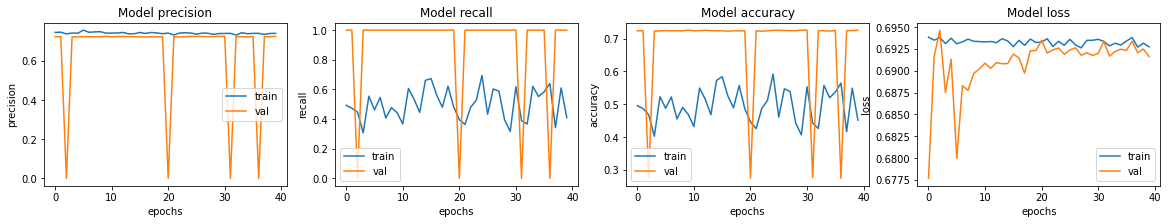

In [52]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [53]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 109ms/step - loss: 0.6923 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 0.6923025846481323,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0


In [54]:
# history_nbn_normal = attempt_nbn()                # BatchNormalization 제거

### 🔥🔥🔥🔥🔥🔥 Attempt-(6) 좌우 반전 Data Augmentation 실시하기

In [ ]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

#### - Augmentation 적용 후 

In [ ]:
# def show_batch(image_batch, label_batch):
#     plt.figure(figsize=(10,10))
#     for n in range(16): # 0~15까지
#         ax = plt.subplot(4,4,n+1)
#         plt.imshow(image_batch[n])
#         if label_batch[n]:# 존재하면? 1이라면 출력해라 라는 의미인가?
#             plt.title("PNEUMONIA")
#         else:
#             plt.title("NORMAL")
#         plt.axis("off")

# image_batch, label_batch = next(iter(train_ds))
# show_batch(image_batch.numpy(), label_batch.numpy())

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

In [ ]:
# history_augmentation = attempt(AUGMENTATION=True)  # Augmentation 실시

## 🔥🔥🔥🔥🔥🔥🔥 Attempt-(7) Data Augmentation: Image Data Generator 사용

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rotation_range = 20,#몸이 좀 틀어진경우(각도?자세?) 
                            horizontal_flip = True,
                            featurewise_std_normalization=True,
                            samplewise_std_normalization=True)
model.fit_generator(datagen.flow(image_batch, label_batch,batch_size=64),steps_per_epoch =len(image_batch)//64,  epochs = 30)

In [ ]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

# 🦋 결과 확인

#### 🌀 Attempt 1

BATCH_SIZE = 16
EPOCHS = 25

<!-- Loss: 0.8919321894645691,
Accuracy: 0.7948718070983887,
Precision: 0.7568627595901489,
Recall: 0.9897435903549194
     -->
    
Loss: 1.3672192096710205,
Accuracy: 0.7323718070983887,
Precision: 0.7023593187332153,
Recall: 0.9923076629638672

---
#### 🌀 Attempt 2

BATCH_SIZE = 8
EPOCHS = 40

Loss: 1.4438451528549194,
Accuracy: 0.7980769276618958,
Precision: 0.7578125,
Recall: 0.9948717951774597

+ optimizer = 


---
#### 🌀 Attempt 3

Loss: 2.936978816986084,
Accuracy: 0.807692289352417,
Precision: 0.7689242959022522,
Recall: 0.9897435903549194

---
#### 🌀 Attempt 4

Loss: 6.804835319519043,
Accuracy: 0.7227563858032227,
Precision: 0.6927176117897034,
Recall: 1.0

---
#### 🌀 Attempt 5

Loss: 0.6923025846481323,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0

---
#### 🌀 Attempt 6

---
#### 🌀 Attempt 7



# 회고 🤗

1. 요즘 살짝 따라가기가 버겁다고 생각했는데,, 새로운 마음가짐으로 임해야겠다고 다짐한 후 하니 나름 재밌었습니다.  

2. 여전히 hyperparameter를 설정하는 건 너무 때려맞추는 느낌이라 감을 익히기 위해서는 더 많은 시도를 해야할 것 같다는 생각이 들었습니다.  

3. `Batch Normalization`만 사용하거나 `Dropout`만 하는 것은 좋지 않은 선택이므로, 둘다 하는 것이 낫겠다는 결론에 이르렀습니다.   

3. Data augmentation이 된 이미지를 `show_batch`하려고 할 때마다 Dead kernel이 뜨는데,,, 뭔가 문제가 있지만 그 문제를 발견하지 못해서 정말 여러차례 돌려보았는데도 너무 시간이 오래걸리고 해서 결국 못찾았습니다..... 시간을 내서 좀 해결해보아야 될 것 같습니다.   
 
4. Image Data Generator는 구글링하다가 참고하게 되었는데 데이터를 이리저리 변형시켜서 새로운 학습 데이터를 만들어주는 것으로 변형의 예시는 회전, 이동 등등 매우 다양합니다. 이것도 사용해보았더니 성능이 나쁘지 않게   

5. 여전히 부족한 것이 많기에 더욱 시간을 투자하고 열정을 쏟아부어야겠다는 다짐을 하게 되었씁니다!!! 🤗 